In [96]:
import itertools
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import LabelEncoder, StandardScaler
import catboost as cb
from scipy.io.arff import loadarff
from typing import Dict, List, Union
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm
from copy import deepcopy
from enum import Enum
from mpl_toolkits import mplot3d
from functools import partial
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [97]:
with open('data/phplE7q6h.arff') as f:
    df = pd.DataFrame(loadarff(f)[0])

In [98]:
cat_features = df.select_dtypes(exclude=[np.number]).drop('Class', axis=1).columns

In [99]:
for col in cat_features:
    df[col] = df[col].apply(lambda x: x.decode('utf-8'))

In [100]:
X, y = df.drop('Class', axis=1), df['Class']
y = LabelEncoder().fit_transform(y)
pool = cb.Pool(X, y, cat_features=list(cat_features))

In [101]:
grid = {
    'iterations': [100, 250, 500, 750, 1000],
    'learning_rate': [0.01, 0.001, 0.0001, 0.0005, 0.00001],
    'depth': [2, 4, 6],
    'l2_leaf_reg': [0.01, 0.1, 10, 100, 1000],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    'random_strength': [0.1, 1.0, 10.0, 100.0],
    'min_data_in_leaf': [1, 5, 10],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'loss_function': ['Logloss'],
    'eval_metric' : ['F1']
}

In [102]:
class UniformRandomSearcher:
    def __init__(self, full_grid: Dict[str, List[Union[float, str, int]]]):
        self.full_grid = full_grid

    def sample(self):
        return {
            k: np.random.choice(v) for k,v in self.full_grid.items()
        }

In [103]:
random_scores = []
random_stds = []
random_chosen_params = []
n_samples = 50
sampler = UniformRandomSearcher(grid)
for i in tqdm(range(n_samples)):
    params = sampler.sample()
    cv_results = cb.cv(pool=pool, params=params, nfold=5, logging_level='Silent')
    last_row = cv_results.iloc[-1]
    last_mean_test, last_std_test = last_row[f'test-F1-mean'], last_row[f'test-F1-std']
    random_scores += [last_mean_test]
    random_stds += [last_std_test]
    random_chosen_params += [params]

100%|██████████| 50/50 [11:25<00:00, 13.71s/it]


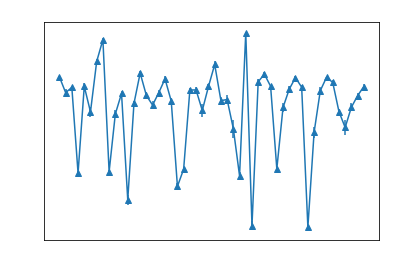

In [104]:
plt.errorbar(list(range(n_samples)), random_scores, random_stds, marker='^')
plt.title('F1-score measurements sampling HyperParams randomly')
plt.xlabel('Iteration')
plt.ylabel('F1-score')
plt.show()

In [105]:
def ubc(means_with_stds, t):
    return means_with_stds[0] + 2 * np.sqrt(np.log(t)) * means_with_stds[1]

def probability_of_improvement(means_with_stds, current_best_f_x):
    return scipy.stats.norm.cdf((means_with_stds[0] - current_best_f_x) / means_with_stds[1])

class AcquisitionFunction(Enum):
    UBC = partial(ubc)
    PI = partial(probability_of_improvement)

In [124]:
class BayesianOptimizer:
    def __init__(self,
                 initial_X: List[Dict[str, Union[float, int, str]]],
                 initial_y: List[float],
                 full_grid: Dict[str, List[Union[float, str, int]]],
                 acquisition_function: AcquisitionFunction,
                 constant_params: List[str],
                 feature_mapper: Dict[str, Dict[str, float]]):
        assert len(initial_X) == len(initial_y)

        def product_dict(**kwargs):
            keys = kwargs.keys()
            vals = kwargs.values()
            for instance in itertools.product(*vals):
                yield dict(zip(keys, instance))

        self.surrogate_function_supplier = GaussianProcessRegressor
        self.acquisition_function = acquisition_function
        self.sampler = UniformRandomSearcher(full_grid)
        self.candidates = pd.DataFrame(product_dict(**full_grid))
        self.constant_params = constant_params
        self.feature_mapper = feature_mapper
        self.dataset = pd.DataFrame()
        self.iter = 1
        for x_samp, y_samp in zip(deepcopy(initial_X), deepcopy(initial_y)):
            self.append(x_samp, y_samp)

    def add_and_sample(self, new_params, new_y):
        self.append(new_params, new_y)
        return self.sample()

    def sample(self):
        model = self.surrogate_function_supplier()
        scaler = StandardScaler()
        X, y = self.dataset.drop('target', axis=1), self.dataset.target
        X = scaler.fit_transform(X)
        model.fit(X, y)

        predicts = model.predict(scaler.transform(pd.DataFrame(
                list(map(lambda x: self.__transform_for_train(x),
                         deepcopy(self.candidates.to_dict('records'))))
            )), return_std=True)

        if self.acquisition_function == AcquisitionFunction.UBC:
            scores = self.acquisition_function.value(predicts, self.iter)
        elif self.acquisition_function == AcquisitionFunction.PI:
            best_on_train = model.predict(X).max()
            scores = self.acquisition_function.value(predicts, best_on_train)
        else:
            raise Exception("Wrong acquisition function.")

        self.iter += 1
        return dict(self.candidates.iloc[scores.argmax()])

    def __transform_for_train(self, params):
        for param in self.constant_params:
            params.pop(param, None)
        for param, mapping in self.feature_mapper.items():
            params[param] = mapping[params[param]]
        return params

    def append(self, params, y):
        self.dataset = self.dataset.append({**self.__transform_for_train(deepcopy(params)), 'target': y}, ignore_index=True)
        self.candidates = self.candidates.loc[self.candidates.apply(lambda x: dict(x) != params, axis=1)]

In [125]:
num_initial = 35
initial_X, initial_y = random_chosen_params[:num_initial], random_scores[:num_initial]
optimizer = BayesianOptimizer(
    initial_X=initial_X,
    initial_y=initial_y,
    full_grid=grid,
    acquisition_function=AcquisitionFunction.PI,
    constant_params=['loss_function', 'eval_metric'],
    feature_mapper={
        'grow_policy': {
            'SymmetricTree': 0.3,
            'Depthwise': 0.5,
            'Lossguide': 0.7
        }
    }
)

In [126]:
n_bayesian_samples = 15
bayesian_scores = []
bayesian_stds = []
bayesian_chosen_params = []

params = {}
last_mean_test = 0
for i in tqdm(range(n_bayesian_samples)):
    if i == 0:
        params = optimizer.sample()
    else:
        params = optimizer.add_and_sample(params, last_mean_test)
    cv_results = cb.cv(pool=pool, params=params, nfold=5, logging_level='Silent')

    last_row = cv_results.iloc[-1]
    last_mean_test, last_std_test = last_row[f'test-F1-mean'], last_row[f'test-F1-std']
    bayesian_scores += [last_mean_test]
    bayesian_stds += [last_std_test]
    bayesian_chosen_params += [params]

100%|██████████| 15/15 [17:43<00:00, 70.93s/it]


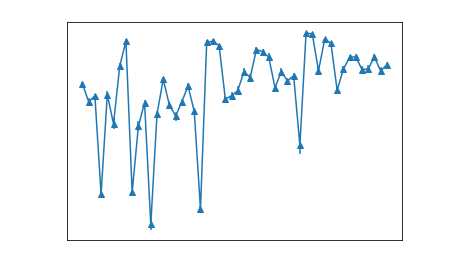

In [109]:
plt.errorbar(range(len(initial_X) + len(bayesian_scores)),
             [*random_scores[:num_initial], *bayesian_scores],
             [*random_stds[:num_initial], *bayesian_stds], marker='^')
plt.title('F1-score measurements sampling HyperParams with BayesianOptimization')
plt.xlabel('Iteration')
plt.ylabel('F1-score')
plt.show()

In [121]:
def dependency_pos(params_list, score, feature1, feature2, feature3):
    COLOR = 'black'
    mpl.rcParams['text.color'] = COLOR
    mpl.rcParams['axes.labelcolor'] = COLOR
    mpl.rcParams['xtick.color'] = COLOR
    mpl.rcParams['ytick.color'] = COLOR

    params_df = pd.DataFrame(params_list)
    params_df['score'] = score
    projection = params_df.groupby([feature1, feature2, feature3])['score'].max()

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    x, y, z = [projection.index.get_level_values(i) for i in range(3)]
    p = ax.scatter3D(x, y, z, c=projection.values, s=100)
    fig.colorbar(p)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

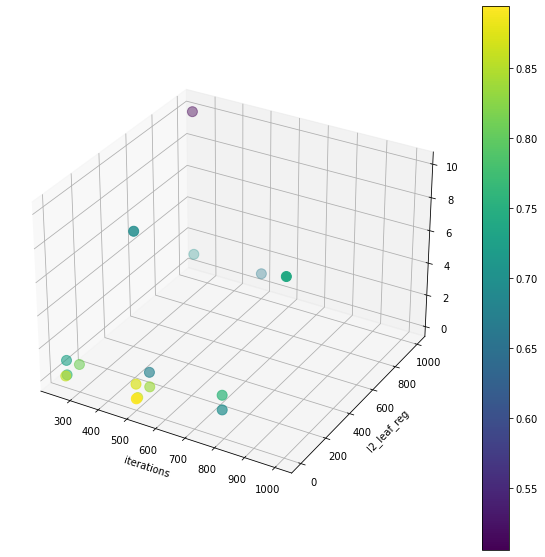

In [122]:
dependency_pos(bayesian_chosen_params, bayesian_scores,
               'iterations', 'l2_leaf_reg', 'random_strength')

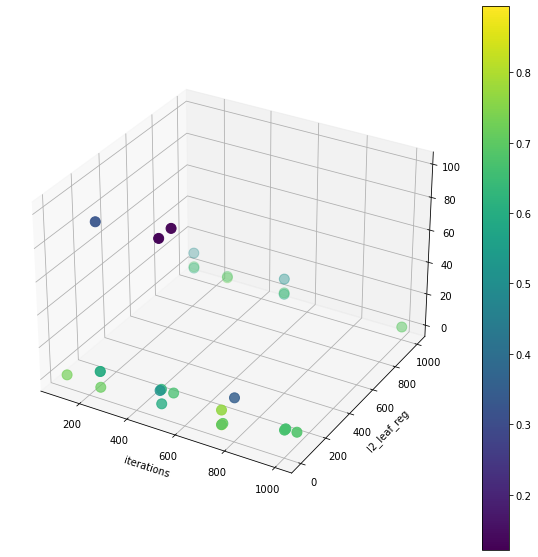

In [123]:
dependency_pos(random_chosen_params[num_initial:], random_scores[num_initial:],
               'iterations', 'l2_leaf_reg', 'random_strength')